# Image Model

In [0]:
#--------------------------------------------------------------------------------------------------------------
# !pip install nuscenes-devkit
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Importing necessary libraries
#--------------------------------------------------------------------------------------------------------------
from nuscenes.nuscenes import NuScenes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import argparse
import random
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input
from keras.models import Model
#--------------------------------------------------------------------------------------------------------------
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 25
INIT_LR = 1e-3
BATCH = 64
IMAGE_DIMS = (128, 128, 3)
#--------------------------------------------------------------------------------------------------------------

In [2]:
#--------------------------------------------------------------------------------------------------------------
# Loading the dataset
#--------------------------------------------------------------------------------------------------------------

datafile = "./drive/My Drive/v1.0-mini/data/Final_Data_2_Changed.csv"
#datafile = "./drive/My Drive/v1.0-mini/data/Final_Sample_Wise_changed.csv"
dataframe = pd.read_csv(datafile)
dataframe.head()
#--------------------------------------------------------------------------------------------------------------

,index,lidar_top,radar_front,radar_front_left,radar_front_right,radar_back_left,radar_back_right,montage_image,bbox_size,num_lidar_pts,num_radar_pts,visibility_token,category_name
0,0,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.621, 0.669, 1.642]",1,0,1,pedestrian
1,1,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.775, 0.769, 1.711]",2,0,2,pedestrian
2,2,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[2.011, 4.633, 1.573]",5,0,3,vehicle_small
3,3,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.752, 0.819, 1.637]",1,0,4,pedestrian
4,4,samples/LIDAR_TOP/n015-2018-07-24-11-22-45+080...,samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0...,samples/RADAR_FRONT_LEFT/n015-2018-07-24-11-22...,samples/RADAR_FRONT_RIGHT/n015-2018-07-24-11-2...,samples/RADAR_BACK_LEFT/n015-2018-07-24-11-22-...,samples/RADAR_BACK_RIGHT/n015-2018-07-24-11-22...,./drive/My Drive/v1.0-mini/samples/MONTAGE/sce...,"[0.427, 0.359, 0.794]",1,0,4,small_objects


In [3]:
#--------------------------------------------------------------------------------------------------------------
# Function to load images from the dataframe
#--------------------------------------------------------------------------------------------------------------
def load_imagesAll(dataframe):
  images = []
  for file in dataframe:
    image = cv2.imread(file)
    image = cv2.resize(image,(128,128))
    images.append(image)
  
  return np.array(images)

def load_images(path):
  image = cv2.imread(path)
  return np.array(image)
#--------------------------------------------------------------------------------------------------------------
# dataframe.shape
#--------------------------------------------------------------------------------------------------------------

(18538, 13)

In [4]:
#--------------------------------------------------------------------------------------------------------------
# Loading images and labels
#--------------------------------------------------------------------------------------------------------------
images = load_imagesAll(dataframe['montage_image'])
labels = dataframe['category_name']
#--------------------------------------------------------------------------------------------------------------
# print(len(labels))
# print(len(images))
#--------------------------------------------------------------------------------------------------------------

18538
18538


In [0]:
#--------------------------------------------------------------------------------------------------------------
# Encoding Labels
#--------------------------------------------------------------------------------------------------------------
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)
#--------------------------------------------------------------------------------------------------------------
images_np = np.array(images)
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, 
                                                    test_size=0.20, random_state=910)
#--------------------------------------------------------------------------------------------------------------
# labels_encoded[67]
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Building model
#--------------------------------------------------------------------------------------------------------------
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
model = make_model(input_shape = (128, 128, 3) , num_classes=4)
keras.utils.plot_model(model, show_shapes=True)
model.summary()
#--------------------------------------------------------------------------------------------------------------

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 64, 64, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Training Model
#--------------------------------------------------------------------------------------------------------------
callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.SGD(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
Hist = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=callbacks, validation_data=(X_test, y_test), shuffle='true'
)
#--------------------------------------------------------------------------------------------------------------

Train on 14830 samples, validate on 3708 samples
Epoch 1/25
14830/14830 [==============================] - 150s 10ms/step - loss: 1.1698 - accuracy: 0.4821 - val_loss: 1.3266 - val_accuracy: 0.4496
Epoch 2/25
14830/14830 [==============================] - 147s 10ms/step - loss: 1.0543 - accuracy: 0.5449 - val_loss: 0.9746 - val_accuracy: 0.5879
Epoch 3/25
14830/14830 [==============================] - 146s 10ms/step - loss: 1.0299 - accuracy: 0.5610 - val_loss: 0.9478 - val_accuracy: 0.5982
Epoch 4/25
14830/14830 [==============================] - 146s 10ms/step - loss: 1.0148 - accuracy: 0.5631 - val_loss: 0.9386 - val_accuracy: 0.5974
Epoch 5/25
14830/14830 [==============================] - 146s 10ms/step - loss: 1.0074 - accuracy: 0.5662 - val_loss: 0.9322 - val_accuracy: 0.6049
Epoch 6/25
14830/14830 [==============================] - 147s 10ms/step - loss: 1.0077 - accuracy: 0.5644 - val_loss: 0.9324 - val_accuracy: 0.6011
Epoch 7/25
14830/14830 [==============================] -

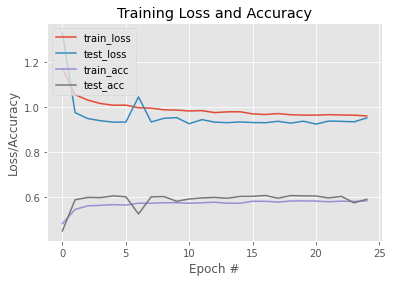

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Plotting Training Loss and Accuracy
#--------------------------------------------------------------------------------------------------------------
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="test_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Extra - Testing on a single image
#--------------------------------------------------------------------------------------------------------------
'''image = cv2.imread("./drive/My Drive/v1.0-mini/Test/Test_1.jpg")
image = cv2.resize(image, (128, 128))
image = np.array(image)
# img_array = tf.expand_dims(image, -1)  # Create batch axis
predictions = model.predict(img_array)
#print(predictions)
score = predictions[0]
print(score)


import tensorflow as tf
img = keras.preprocessing.image.load_img(
    "./drive/My Drive/v1.0-mini/Test/Test_3.jpg", target_size=(128,128)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
print(img_array.shape)
predictions = model.predict(img_array)
score = predictions[0]
print(score)
for i in range(0,4):
  print("Prediction Score for", le.classes_[i],": ", score[i]*100)

'''
#--------------------------------------------------------------------------------------------------------------

In [0]:
#--------------------------------------------------------------------------------------------------------------
# Saving Model for later use
#--------------------------------------------------------------------------------------------------------------
model.save("./drive/My Drive/v1.0-mini/model/image_model.h5")  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = keras.models.load_model("./drive/My Drive/v1.0-mini/model/image_model.h5")
#--------------------------------------------------------------------------------------------------------------